In [1]:
import cmdstanpy as stan
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import poisson, geom
import seaborn as sns
import shapefile
import shelve
from tqdm import tqdm
import ujson
import yaml

In [2]:
rg = np.random.default_rng(1)

## Zip code adjacency

In [3]:
pz_adj = yaml.safe_load(open("../data/parentadj.yaml", "r"))

In [4]:
allpzs = list(sorted(set(v for a, b in pz_adj.items() for v in (a, *b))))
pz_edges = set(
    (int(a), int(b)) if a <= b else (int(b), int(a))
    for a, bs in pz_adj.items()
    for b in bs
)
Nzips = len(allpzs)
Nzips

180

In [5]:
pz2i = {pz: i for i, pz in enumerate(allpzs, 1)}
i2pz = dict(enumerate(allpzs, 1))

In [6]:
i_edges = [(pz2i[pza], pz2i[pzb]) for pza, pzb in pz_edges]
node1, node2 = map(list, zip(*i_edges))
N_edges = len(node1)
N_edges, len(i_edges)

(379, 379)

In [7]:
A = np.zeros((Nzips, Nzips))
for i, j in i_edges:
    A[i - 1, j - 1] = A[j - 1, i - 1] = 1
np.savetxt("A.csv", A)

In [8]:
# computed in R from A -- see info in BYM block below
scaling_factor = 0.8698889

## Data loading and subsampling

In [9]:
bikedf = pd.read_csv("../data/bikedf.csv.gz")

In [10]:
bikedf["rush_hour"] = bikedf["rush_hour2"]

In [11]:
bikedf["pzi"] = [pz2i[int(z)] for z in bikedf["pzip"]]

In [12]:
def get_sample(N=None):
    if N is not None:
        s = bikedf.sample(N, random_state=rg.bit_generator)
    else:
        s = bikedf
    return s, {
        "N": len(s),
        "Nzips": Nzips,
        "N_edges": N_edges,
        "B": 5,
        "scaling_factor": scaling_factor,
        "nighttime": s["nighttime"].values.astype(int).tolist(),
        "rush_hour": s["rush_hour"].values.astype(int).tolist(),
        "manhattan": s["manhattan"].values.astype(int).tolist(),
        "staten": s["staten"].values.astype(int).tolist(),
        "brooklyn": s["brooklyn"].values.astype(int).tolist(),
        "queens": s["queens"].values.astype(int).tolist(),
        "bronx": s["bronx"].values.astype(int).tolist(),
        "borough": s["boro"].values.astype(int).tolist(),
        "injury": s["injury"].values.astype(int).tolist(),
        "latitude": s["lat"].values.tolist(),
        "longitude": s["long"].values.tolist(),
        "neighborhood": s["pzi"].values.tolist(),
        "node1": node1,
        "node2": node2,
    }

In [13]:
sample_df, sample = get_sample(10000)
nighttime = np.array(sample["nighttime"]).astype(bool)
injury = np.array(sample["injury"])
rush_hour = np.array(sample["rush_hour"]).astype(bool)
manhattan = np.array(sample["manhattan"]).astype(bool)
brooklyn = np.array(sample["brooklyn"]).astype(bool)
queens = np.array(sample["queens"]).astype(bool)
bronx = np.array(sample["bronx"]).astype(bool)
borough = np.array(sample["borough"])
latitude = np.array(sample["latitude"])
longitude = np.array(sample["longitude"])
staten = np.array(sample["staten"]).astype(bool)
bike_data = '/tmp/10k_bikedata.json'
with open(bike_data, 'w') as f:
    f.write(ujson.dumps(sample))

## Stan helper library

In [14]:
def get_model(path, code):
    with open(path, "w") as f:
        f.write(code)
    model = stan.CmdStanModel(stan_file=path)
    return model

## Model code / Stan fitting

We'll fit the models here and make plots at the bottom.

### Global model -- no spatial / borough aspect

In [15]:
glob = get_model("10k_stan/bike_glob.stan",
'''
data {
  int<lower=0> N;
  int<lower=0,upper=1> nighttime[N];
  int<lower=0,upper=1> rush_hour[N];
  int<lower=0,upper=1> injury[N];
}
parameters {
  real b_nighttime;
  real b_rush_hour;
  real intercept;
}
model {
  injury ~ bernoulli_logit(
      b_nighttime * to_vector(nighttime)
      + b_rush_hour * to_vector(rush_hour)
      + intercept
  );
  intercept ~ normal(0, 1);
  b_nighttime ~ normal(0, 1);
  b_rush_hour ~ normal(0, 1);
}
generated quantities {
  vector[N] pred_means;
  pred_means = inv_logit(
      b_nighttime * to_vector(nighttime)
      + b_rush_hour * to_vector(rush_hour)
      + intercept
  );
  vector[N] residuals = to_vector(injury) - pred_means;
  int injury_rep[N] = bernoulli_rng(pred_means);
}
''')

INFO:cmdstanpy:compiling stan program, exe file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_glob
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_glob


In [16]:
glob_fit = glob.sample(data=bike_data, output_dir='10k_stan_output')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


### Borough-by-borough model, separate model for each borough

In [17]:
nopool = get_model("10k_stan/bike_nopool.stan",
'''
data {
  int<lower=0> N;
  int<lower=0> B; 
  int<lower=0,upper=1> nighttime[N];
  int<lower=0,upper=1> rush_hour[N];
  int<lower=1,upper=B> borough[N];
  int<lower=0,upper=1> injury[N];
}
parameters {
  real b_nighttime[B];
  real b_rush_hour[B];
  real intercept[B];
}
model {
  injury ~ bernoulli_logit(
    to_vector(b_nighttime[borough]) .* to_vector(nighttime)
    + to_vector(b_rush_hour[borough]) .* to_vector(rush_hour)
    + to_vector(intercept[borough])
  );
  intercept ~ normal(0, 1);
  b_nighttime ~ normal(0, 1);
  b_rush_hour ~ normal(0, 1);
}
generated quantities {
  vector[N] pred_means = inv_logit(
    to_vector(b_nighttime[borough]) .* to_vector(nighttime)
    + to_vector(b_rush_hour[borough]) .* to_vector(rush_hour)
    + to_vector(intercept[borough])
  );
  vector[N] residuals = to_vector(injury) - pred_means;
  int injury_rep[N] = bernoulli_rng(pred_means);
}
''')

INFO:cmdstanpy:compiling stan program, exe file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_nopool
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_nopool


In [18]:
nopool_fit = nopool.sample(data=bike_data, output_dir='10k_stan_output')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


### Boroughs with pooling

In [19]:
pool = get_model("10k_stan/bike_pool.stan",
'''
data {
  int<lower=0> N;
  int<lower=0> B; 
  int<lower=0,upper=1> nighttime[N];
  int<lower=0,upper=1> rush_hour[N];
  int<lower=1,upper=B> borough[N];
  int<lower=0,upper=1> injury[N];
}
parameters {
  real mu_nighttime;
  real mu_rush_hour;
  real mu_intercept;
  real<lower=0> sigma_nighttime;
  real<lower=0> sigma_rush_hour;
  real<lower=0> sigma_intercept;
  real b_nighttime[B];
  real b_rush_hour[B];
  real intercept[B];
}
model {  
  b_nighttime ~ normal(mu_nighttime, sigma_nighttime);
  b_rush_hour ~ normal(mu_rush_hour, sigma_rush_hour);
  intercept ~ normal(mu_intercept, sigma_intercept);
  mu_nighttime ~ normal(0, 1);
  mu_rush_hour ~ normal(0, 1);
  mu_intercept ~ normal(0, 1);
  
  injury ~ bernoulli_logit(
    to_vector(b_nighttime[borough]) .* to_vector(nighttime)
    + to_vector(b_rush_hour[borough]) .* to_vector(rush_hour)
    + to_vector(intercept[borough])
  );
}
generated quantities {
  vector[N] pred_means = inv_logit(
    to_vector(b_nighttime[borough]) .* to_vector(nighttime)
    + to_vector(b_rush_hour[borough]) .* to_vector(rush_hour)
    + to_vector(intercept[borough])
  );
  vector[N] residuals = to_vector(injury) - pred_means;
  int injury_rep[N] = bernoulli_rng(pred_means);
}
''')

INFO:cmdstanpy:compiling stan program, exe file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_pool
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_pool


In [20]:
pool_fit = pool.sample(data=bike_data, output_dir='10k_stan_output')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


### ICAR by zip code

In [21]:
icar = get_model("10k_stan/bike_icar.stan",
'''
functions {
  real icar_normal_lpdf(vector phi, int[] node1, int[] node2) {
    return (
      -0.5 * dot_self(phi[node1] - phi[node2])
      + normal_lpdf(sum(phi) | 0, 0.01 * rows(phi))
    );
  }
}

data {
  int<lower=0> N;
  int<lower=0> Nzips;
  int<lower=0> N_edges;
  int<lower=0, upper=Nzips> neighborhood[N];
  int<lower=1, upper=N> node1[N_edges];
  int<lower=1, upper=N> node2[N_edges];
  int<lower=0, upper=1> injury[N];
  int<lower=0,upper=1> nighttime[N];
  int<lower=0,upper=1> rush_hour[N];
}

parameters {
  real<lower=0> sigma_phi;
  vector[Nzips] phi;
  real b_nighttime;
  real b_rush_hour;
  real intercept;
}

model {
  injury ~ bernoulli_logit(
      intercept
      + phi[neighborhood] * sigma_phi
      + b_nighttime * to_vector(nighttime)
      + b_rush_hour * to_vector(rush_hour)
    );
    
  phi ~ icar_normal(node1, node2);
  sigma_phi ~ normal(0, 5);
  intercept ~ normal(0, 1);
  b_nighttime ~ normal(0, 1);
  b_rush_hour ~ normal(0, 1);
}

generated quantities {
  vector[N] pred_means = inv_logit(
    intercept
    + (phi * sigma_phi)[neighborhood]
    + b_nighttime * to_vector(nighttime)
    + b_rush_hour * to_vector(rush_hour)
  );
  vector[N] residuals = to_vector(injury) - pred_means;
  vector[Nzips] zip_pred_means = inv_logit(
    intercept
    + phi * sigma_phi
  );
  int injury_rep[N] = bernoulli_rng(pred_means);
}
''')

INFO:cmdstanpy:compiling stan program, exe file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_icar
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_icar


In [22]:
icar_fit = icar.sample(data=bike_data, output_dir='10k_stan_output')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


## Besag-York-Mollié

see Gelman article https://pubmed.ncbi.nlm.nih.gov/31677766/ pdf at http://www.stat.columbia.edu/~gelman/research/published/bym_article_SSTEproof.pdf

this is BYM2 described in that article

idea: add a non-spatially-correlated noise modeling term to handle the overdispersion in the ~~Poisson~~ logistic regression model

In [23]:
# need to compute this $s$ aka `scaling_factor`
# paper says they use https://rdrr.io/github/INBO-BMK/INLA/man/scale.model.html to compute it
# I used M. Morris code at https://github.com/stan-dev/example-models/blob/master/knitr/car-iar-poisson/update_2021_02/bym2_helpers.R
# variable definition appears at the top so that this is stored in the json
# so we can pass to stan in the data block
# scaling_factor = 0.8698889

In [24]:
bym = get_model("10k_stan/bike_bym.stan",
'''
functions {
  real icar_normal_lpdf(vector phi, int[] node1, int[] node2) {
    return (
      -0.5 * dot_self(phi[node1] - phi[node2])
      + normal_lpdf(sum(phi) | 0, 0.01 * rows(phi))
    );
  }
}

data {
  int<lower=0> N;
  int<lower=0> Nzips;
  int<lower=0> N_edges;
  int<lower=0, upper=Nzips> neighborhood[N];
  int<lower=1, upper=N> node1[N_edges];
  int<lower=1, upper=N> node2[N_edges];
  int<lower=0, upper=1> injury[N];
  int<lower=0,upper=1> nighttime[N];
  int<lower=0,upper=1> rush_hour[N];
  real<lower=0> scaling_factor;
}

parameters {
  // real logit_rho;
  real<lower=0, upper=1> rho;
  vector[Nzips] phi;         // spatial effects
  vector[Nzips] theta;       // heterogeneous effects
  real<lower=0> sigma_bym;
  
  real b_nighttime;
  real b_rush_hour;
  real intercept;
}

transformed parameters {
  vector[Nzips] convolved_re = sigma_bym * (
    sqrt(rho / scaling_factor) * phi
    + sqrt(1 - rho) * theta
  );
}

model {
  injury ~ bernoulli_logit(  
    intercept
    + b_nighttime * to_vector(nighttime)
    + b_rush_hour * to_vector(rush_hour)
    + convolved_re[neighborhood]
  );

  intercept ~ normal(0, 1);
  b_nighttime ~ normal(0, 1);
  b_rush_hour ~ normal(0, 1);
  
  rho ~ beta(0.5, 0.5);
  sigma_bym ~ normal(0, 5);
  theta ~ normal(0, 1);
  phi ~ icar_normal(node1, node2);
}

generated quantities {
  vector[N] pred_means = inv_logit(
    intercept
    + b_nighttime * to_vector(nighttime)
    + b_rush_hour * to_vector(rush_hour)
    + convolved_re[neighborhood]
  );
  vector[N] residuals = to_vector(injury) - pred_means;
  vector[Nzips] zip_pred_means = inv_logit(
    intercept
    + convolved_re[neighborhood] * sigma_bym
  );
  int injury_rep[N] = bernoulli_rng(pred_means);
}
''')

INFO:cmdstanpy:compiling stan program, exe file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_bym
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_bym


In [25]:
bym_fit = bym.sample(data=bike_data, output_dir='10k_stan_output')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


## Zip code pooling model

In [26]:
zippool = get_model("10k_stan/bike_zippool.stan",
'''
data {
  int<lower=0> N;
  int<lower=0> Nzips; 
  int<lower=0,upper=1> nighttime[N];
  int<lower=0,upper=1> rush_hour[N];
  int<lower=1,upper=Nzips> neighborhood[N];
  int<lower=0,upper=1> injury[N];
}
parameters {
  real mu_nighttime;
  real mu_rush_hour;
  real mu_intercept;

  real<lower=0> sigma_nighttime;
  real<lower=0> sigma_rush_hour;
  real<lower=0> sigma_intercept;

  real b_nighttime[Nzips];
  real b_rush_hour[Nzips];
  real intercept[Nzips];
}
model {  
  b_nighttime ~ normal(mu_nighttime, sigma_nighttime);
  b_rush_hour ~ normal(mu_rush_hour, sigma_rush_hour);
  intercept ~ normal(mu_intercept, sigma_intercept);
  
  mu_nighttime ~ normal(0, 1);
  mu_rush_hour ~ normal(0, 1);
  mu_intercept ~ normal(0, 1);
  
  injury ~ bernoulli_logit(
    to_vector(b_nighttime[neighborhood]) .* to_vector(nighttime)
    + to_vector(b_rush_hour[neighborhood]) .* to_vector(rush_hour)
    + to_vector(intercept[neighborhood])
  );
}
generated quantities {
  vector[N] pred_means = inv_logit(
    to_vector(b_nighttime[neighborhood]) .* to_vector(nighttime)
    + to_vector(b_rush_hour[neighborhood]) .* to_vector(rush_hour)
    + to_vector(intercept[neighborhood])
  );
  vector[N] residuals = to_vector(injury) - pred_means;
  vector[Nzips] zip_pred_means = inv_logit(to_vector(intercept[neighborhood]));
  int injury_rep[N] = bernoulli_rng(pred_means);
}
''')

INFO:cmdstanpy:compiling stan program, exe file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_zippool
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_zippool


In [27]:
zippool_fit = zippool.sample(data=bike_data, output_dir='10k_stan_output')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [28]:
intzippool = get_model("10k_stan/bike_intzippool.stan",
'''
data {
  int<lower=0> N;
  int<lower=0> Nzips; 
  int<lower=0,upper=1> nighttime[N];
  int<lower=0,upper=1> rush_hour[N];
  int<lower=1,upper=Nzips> neighborhood[N];
  int<lower=0,upper=1> injury[N];
}
parameters {
  real mu_intercept;
  real<lower=0> sigma_intercept;

  real b_nighttime;
  real b_rush_hour;
  real intercept[Nzips];
}
model {  
  b_nighttime ~ normal(0, 1);
  b_rush_hour ~ normal(0, 1);
  intercept ~ normal(mu_intercept, sigma_intercept);
  
  mu_intercept ~ normal(0, 1);
  
  injury ~ bernoulli_logit(
    b_nighttime * to_vector(nighttime)
    + b_rush_hour * to_vector(rush_hour)
    + to_vector(intercept[neighborhood])
  );
}
generated quantities {
  vector[N] pred_means = inv_logit(
    b_nighttime * to_vector(nighttime)
    + b_rush_hour * to_vector(rush_hour)
    + to_vector(intercept[neighborhood])
  );
  vector[N] residuals = to_vector(injury) - pred_means;
  vector[Nzips] zip_pred_means = inv_logit(to_vector(intercept[neighborhood]));
  int injury_rep[N] = bernoulli_rng(pred_means);
}
''')

INFO:cmdstanpy:compiling stan program, exe file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_intzippool
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/charlie/Desktop/apsta2/apsta-proj/ipynb/10k_stan/bike_intzippool


In [29]:
intzippool_fit = intzippool.sample(data=bike_data, output_dir='10k_stan_output')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


## Model checking library

Below, we have some model checks.

For the first model check, we plot the average residuals by borough. I.e., if $C_b$ is the set of row indices $n$ such that that row corresponds to an observation in borough $b$, and if $N_b=\lvert C_b\rvert$, we plot $$\frac1{N_b}\sum_{n\in C_b}^N (y_n - \hat{y}_\beta),$$
where the histogram is taken over Stan's draws of model parameters $\beta$. We also plot the mean over all $\beta$ as a black vertical line. This is inspired by a similar procedure also applied to a logistic regression model in Prof. Gelman's paper "Diagnostic checks for discrete data regression models using posterior predictive simulations", http://www.stat.columbia.edu/~gelman/research/published/dogs.pdf.

### a model can be inspected with these if...

 - it has the `residuals` in the generated quantities
 - it has `pred_means` in generated quantities
 - Moran and Geary require `injury_rep`



In [30]:
gray = "silver"
blue = "navy"
red = "darkred"
green = "darkgreen"

In [31]:
def avg_residual_plot(fit, name, axes=None):
    own = False
    if axes is None:
        own = True
        fig, axes = plt.subplots(5, 1, sharex=True, figsize=(6, 8))
        
    mars = {}
    
    for ax, n, b in zip(
        axes,
        ("Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"),
        (bronx, brooklyn, manhattan, queens, staten),
    ):
        x = fit.stan_variable("residuals")[:, b].mean(axis=1)
        ax.hist(x, bins=32, label="Average residuals", histtype="stepfilled", color=gray, ec=gray)
        
        if own:
            ax.set_title(n)
        else:
            ax.axvline(0, color="k", lw=1)
            
        ax.set_yticks([])
        mar = x.mean()
        if own:
            ax.axvline(mar, color=blue, label="Mean average residual")
        mars[n] = mar
        
    sns.despine(left=True, top=True, right=True)
    
    if own:
        axes.flat[-1].set_xlabel("Average residual")
        axes.flat[0].legend()
        plt.savefig(f"10k_figs/{name}_avg_res.pdf")
        fig.suptitle("Average residuals by borough")
        plt.tight_layout()
        plt.show()
    else:
        h = axes.flat[0].set_ylabel(r"\begin{center}" + name.replace(" (", "\\\\ (") + r"\end{center}")
        h.set_rotation(0)
        # axes.flat[0].yaxis.set_label_coords(0, 0.25)
        
    return fit.stan_variable("residuals").mean(), mars

In [32]:
def injury_prob_plot(fit, name, axes=None, oos=None):
    
    own = False
    if axes is None:
        own = True
        fig, axes = plt.subplots(5, 1, sharex=True, figsize=(6, 8))
    
    pred_means = fit.stan_variable("pred_means")
    draws = rg.binomial(1, pred_means)
    injuries_tot = draws.sum(axis=1)
    
    post_ps = {}
    
    for ax, n, b in zip(
        axes,
        ("Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"),
        (bronx, brooklyn, manhattan, queens, staten),
    ):
        draws_in_boro = draws[:, b]
        pps = draws_in_boro.mean(axis=1)
        ax.hist(pps, label="Posterior sample proportion", histtype="stepfilled", color=gray, ec=gray, bins=32)
        obs = injury[b].mean()
        ax.axvline(obs, color=red, label="Observed proportion")
        if oos is not None:
            oos_b = oos["injury"][b].mean()
            ax.axvline(oos_b, color=green, label="Heldout proportion")
        post_p = min((pps > obs).mean(), (pps < obs).mean())
        post_ps[n] = post_p
        if own:
            ax.set_title(n)
        ax.set_yticks([])
    
    sns.despine(left=True, top=True, right=True)
    if own:
        axes.flat[-1].set_xlabel("Proportion injured")
        axes.flat[0].legend()
        fig.suptitle("Estimated and observed proportion injured by borough")
        plt.tight_layout()
        plt.savefig(f"10k_figs/{name}_injury_prob.pdf")
        plt.show()
    else:
        h = axes.flat[0].set_ylabel(r"\begin{center}" + name.replace(" (", "\\\\ (") + r"\end{center}")
        h.set_rotation(0)
        # axes.flat[0].yaxis.set_label_coords(0, 0.25)
        
    return post_ps

### Moran's $I$ and Geary's $C$

These are two ways of measuring spatial autocorrelation. Moran apparently measures global spatial autocorrelation and Geary measures local, maybe Geary will be better here so let's try both. For a review see https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0068336 -- an interesting note is that Moran's is a natural generalization of Pearson's $r$, and Geary's is a generalization of the Durbin-Watson statistic.

These will be done with zip codes as the spatial index, and the adjacency matrix $A$ as the weights. These statistics both require single observations per neihborhood, so I will take the mean over the neighborhood (injury rate per each neighborhood) and also compute a grand mean of means, and these will be $\bar{y}_i$ and $\bar{\bar{y}}$ in the formulas below.

Let $N_{\text{zip}}$ be the number of zip codes and $N_{\text{edges}}=\sum_{i<j}A_{i,j}$.

With that set, Moran's $I$ is given by $$
I
=
\frac{N_{\text{zip}}}{2 N_{\text{edges}}}
\frac{
\sum_{i}\sum_j A_{i,j}(\bar{y}_i-\bar{\bar{y}})(\bar{y}_j-\bar{\bar{y}})
}{
\sum_i (\bar{y}_i-\bar{\bar{y}})^2
}
=
\frac{N_{\text{zip}}}{N_{\text{edges}}}
\frac{
\sum_{i<j} A_{i,j}(\bar{y}_i-\bar{\bar{y}})(\bar{y}_j-\bar{\bar{y}})
}{
\sum_i (\bar{y}_i-\bar{\bar{y}})^2
}.
$$
And, Geary's $C$ is given by $$
C
=
\frac{N_{\text{zip}} - 1}{4 N_{\text{edges}}}
\frac{
\sum_i\sum_j A_{ij} (\bar{y}_i - \bar{y}_j)^2
}{
\sum_i (\bar{y}_i - \bar{\bar{y}})^2
}
=
\frac{N_{\text{zip}} - 1}{2 N_{\text{edges}}}
\frac{
\sum_{i<j} A_{ij} (\bar{y}_i - \bar{y}_j)^2
}{
\sum_i (\bar{y}_i - \bar{\bar{y}})^2
}.
$$

We can use these as a posterior predictive check to see if the models are capturing the autocorrelation present in the data by plotting the posterior distribution and seeing how the observed statistics line up. To plot the posterior of these, we will simulate posterior draws of entire datasets for each MCMC parameter sample, which will be expensive, but we already do this for the residuals so its not going to be much worse.

Here we have some functions to compute these.

In [33]:
# both Moran's and Geary's will want the ybars as input, so I
# am factoring out the shared code here. this computes the ybar_i and ybarbar
# described above
# y[j] is observation j, pzi[j] is (parent) zip id of observation j,
def zip_means_table(pzi, y):
    table = pd.crosstab(pd.Series(pzi, name="pzi"), pd.Series(y, name="injury"))
    ybars = table[1] / table.sum(axis=1)
    return ybars

In [34]:
obs_means_table = zip_means_table(sample["neighborhood"], sample["injury"])
obs_means_table

pzi
1      0.717557
2      0.831818
3      0.733990
4      0.750000
5      0.789474
         ...   
175    0.764706
176    0.888889
177    0.857143
178    0.846154
179    1.000000
Length: 174, dtype: float64

In [35]:
# heldout_means_table = zip_means_table(heldout_df["pzi"], heldout_df["injury"])
# heldout_means_table

In [36]:
def moran_i(table):
    pzi, means = table.index.values, table.values
    A_these_zips = A[pzi - 1][:, pzi - 1]
    grand_mean = means.mean()
    devs = means - grand_mean
    sxx = np.sum(np.square(devs))
    sxy = devs.T @ A_these_zips @ devs
    return (Nzips / (2 * N_edges)) * (sxy / sxx)

In [37]:
obs_moran = moran_i(obs_means_table)
obs_moran

0.28645612421405964

In [38]:
# oos_moran = moran_i(heldout_means_table)
# oos_moran

In [39]:
def geary_c(table):
    pzi, means = table.index.values, table.values
    A_these_zips = A[pzi - 1][:, pzi - 1]
    grand_mean = means.mean()
    devs = means - grand_mean
    sxx = np.sum(np.square(devs))
    ss = np.sum(A_these_zips * np.square(np.subtract.outer(means, means)))
    return ((Nzips - 1) / (4 * N_edges)) * (ss / sxx)

In [40]:
obs_geary = geary_c(obs_means_table)
obs_geary

0.5921476641103021

In [41]:
# oos_geary = geary_c(heldout_means_table)
# oos_geary

now some code for making histograms of these two things given model reps

In [42]:
def spatial_autocorrelation_check(fit, name):
    morans, gearys = [], []
    for yrep in fit.stan_variable("injury_rep"):
        table = zip_means_table(sample["neighborhood"], yrep)
        morans.append(moran_i(table))
        gearys.append(geary_c(table))
    morans = np.array(morans)
    gearys = np.array(gearys)
    
    moran_post_p = min((morans > obs_moran).mean(), (morans < obs_moran).mean())
    geary_post_p = min((gearys > obs_geary).mean(), (gearys < obs_geary).mean())
        
    fig, (aa, ab) = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
    aa.hist(morans, density=True, label="posterior histogram", bins=32, histtype="stepfilled", color=gray, ec=gray)
    aa.set_xlabel("Moran's I")
    aa.axvline(obs_moran, color=red, label="observed")
    ab.hist(gearys, density=True, label="posterior histogram", bins=32, histtype="stepfilled", color=gray, ec=gray)
    ab.set_xlabel("Geary's C")
    ab.axvline(obs_geary, color=red, label="observed")
    sns.despine(left=True, top=True, right=True)
    aa.set_yticks([])
    ab.set_yticks([])
    ab.legend(bbox_to_anchor=(1.05, 1))
    plt.savefig(f"10k_figs/{name}_spatial.pdf")
    plt.show()
    return moran_post_p, geary_post_p

## Model checks

The plots we promised!

In [43]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

### Global model -- no spatial / borough aspect

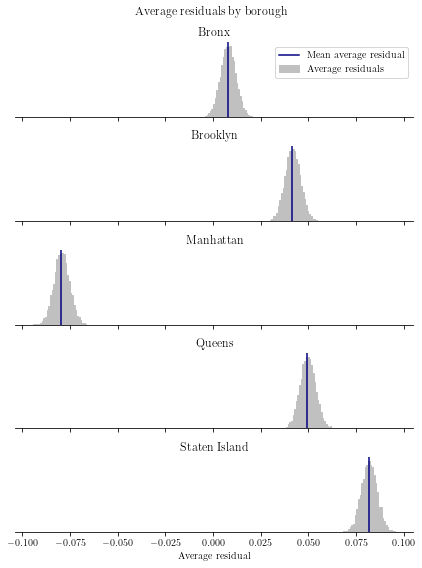

In [44]:
glob_mar, glob_mars = avg_residual_plot(glob_fit, "glob")

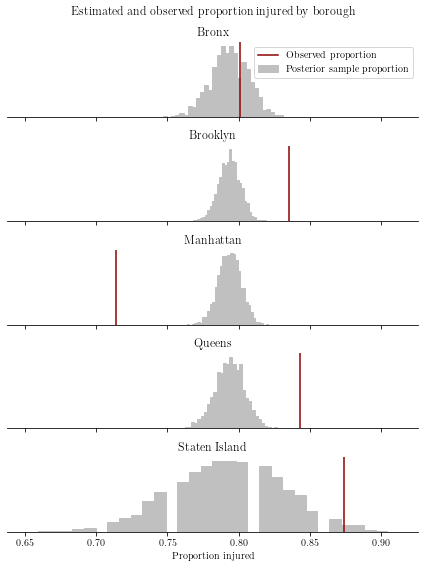

In [45]:
glob_injury_post_ps = injury_prob_plot(glob_fit, "glob")

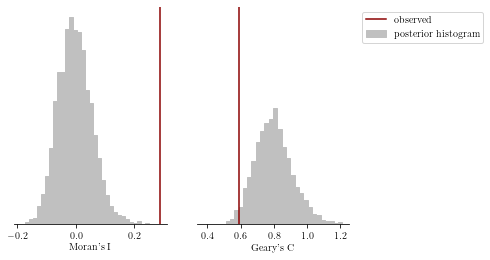

In [46]:
glob_moran_p, glob_geary_p = spatial_autocorrelation_check(glob_fit, "glob")

### Borough-by-borough model, separate model for each borough

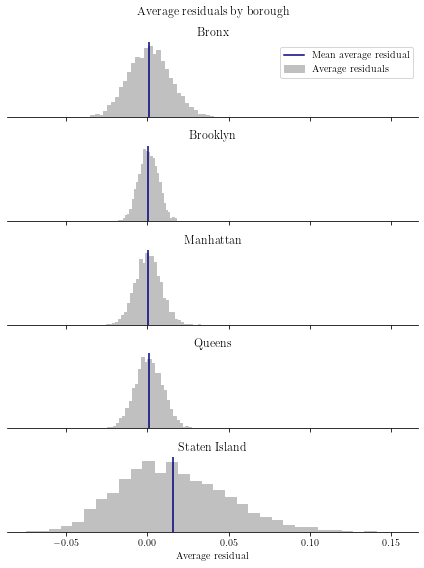

In [47]:
nopool_mar, nopool_mars = avg_residual_plot(nopool_fit, "nopool")

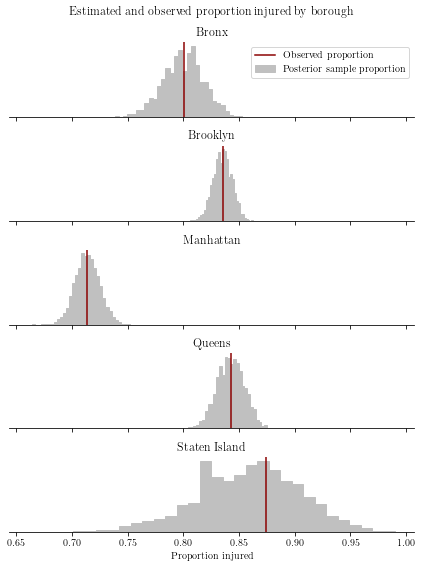

In [48]:
nopool_injury_post_ps = injury_prob_plot(nopool_fit, "nopool")

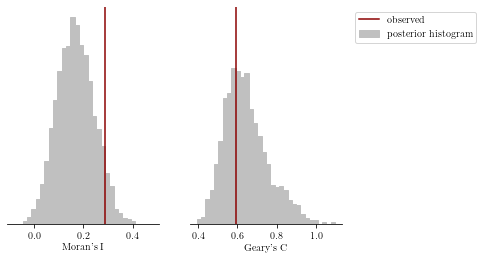

In [49]:
nopool_moran_p, nopool_geary_p = spatial_autocorrelation_check(nopool_fit, "nopool")

### Boroughs with pooling

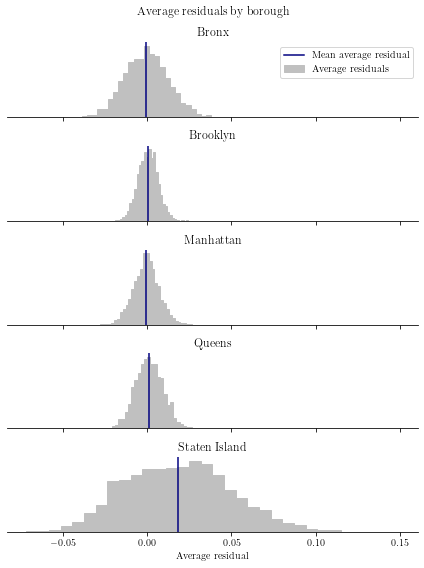

In [50]:
pool_mar, pool_mars = avg_residual_plot(pool_fit, "pool")

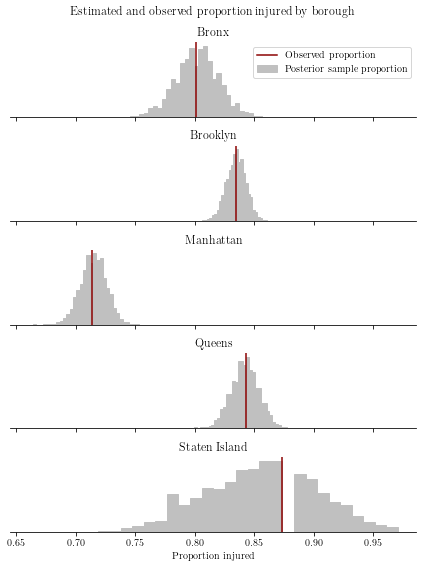

In [51]:
pool_injury_post_ps = injury_prob_plot(pool_fit, "pool")

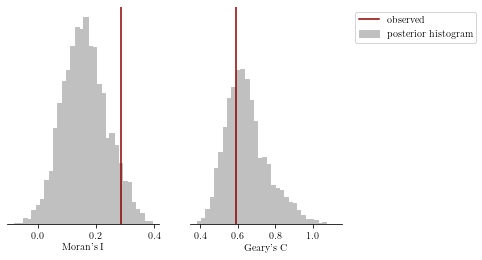

In [52]:
pool_moran_p, pool_geary_p = spatial_autocorrelation_check(pool_fit, "pool")

### ICAR by zip code

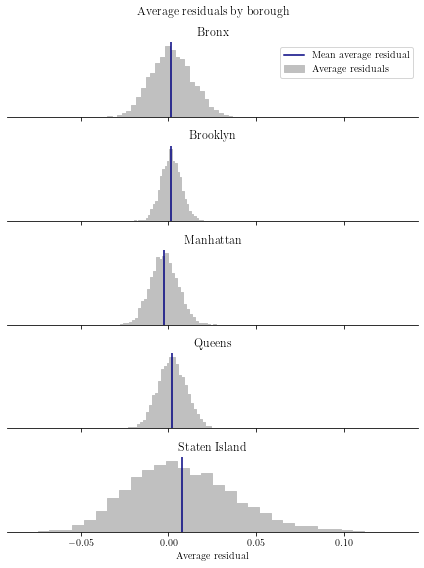

In [53]:
icar_mar, icar_mars = avg_residual_plot(icar_fit, "icar")

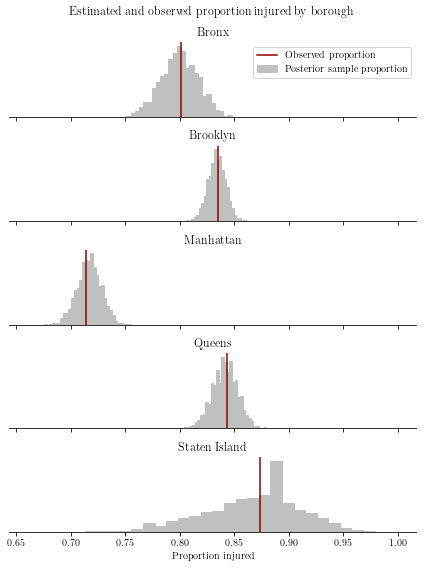

In [54]:
icar_injury_post_ps = injury_prob_plot(icar_fit, "icar")

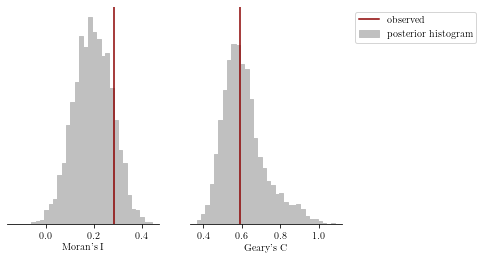

In [55]:
icar_moran_p, icar_geary_p = spatial_autocorrelation_check(icar_fit, "icar")

### BYM by zip code

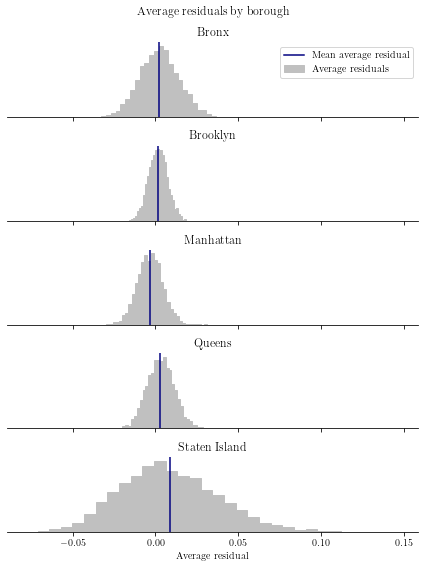

In [56]:
bym_mar, bym_mars = avg_residual_plot(bym_fit, "bym")

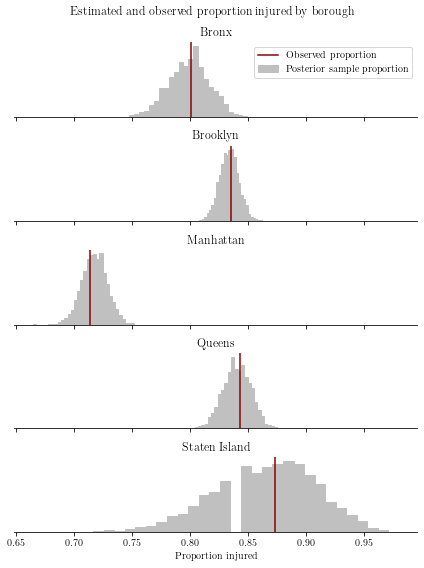

In [57]:
bym_injury_post_ps = injury_prob_plot(bym_fit, "bym")

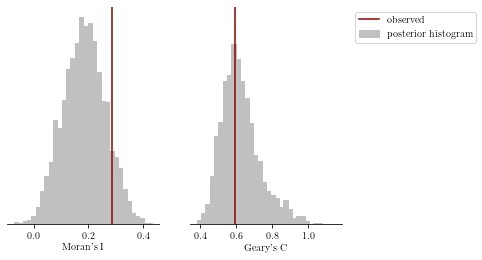

In [58]:
bym_moran_p, bym_geary_p = spatial_autocorrelation_check(bym_fit, "bym")

### Zip code pooling

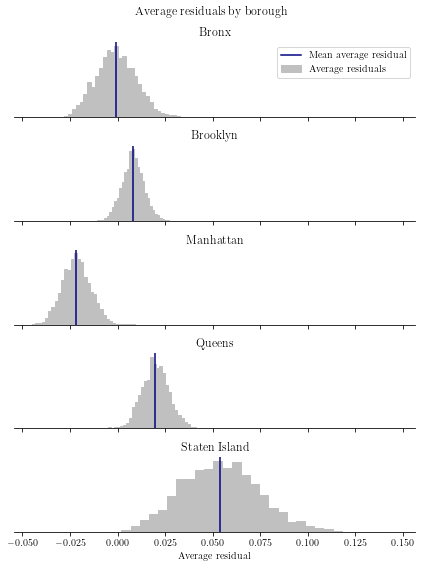

In [59]:
zippool_mar, zippool_mars = avg_residual_plot(zippool_fit, "zippool")

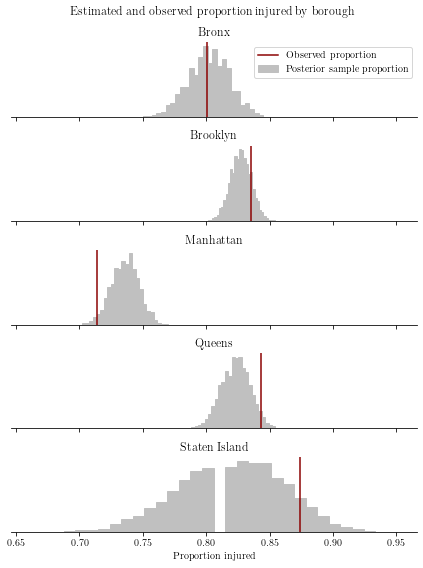

In [60]:
zippool_injury_post_ps = injury_prob_plot(zippool_fit, "zippool")

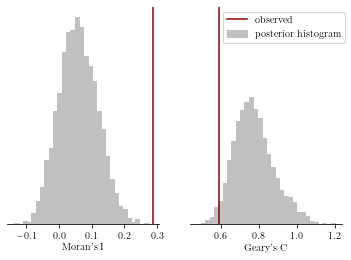

In [61]:
zippool_moran_p, zippool_geary_p = spatial_autocorrelation_check(zippool_fit, "zippool")

### Zip code pooling, global slopes (only intercept varies by borough)

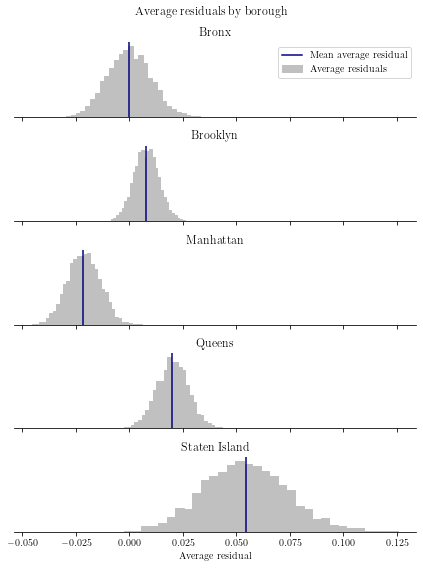

In [62]:
intzippool_mar, intzippool_mars = avg_residual_plot(intzippool_fit, "intzippool")

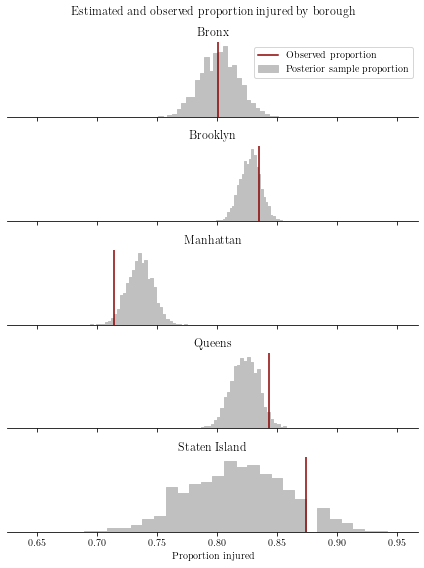

In [63]:
intzippool_injury_post_ps = injury_prob_plot(intzippool_fit, "intzippool")

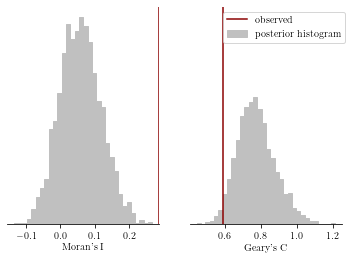

In [64]:
intzippool_moran_p, intzippool_geary_p = spatial_autocorrelation_check(intzippool_fit, "intzippool")

### All model morans

In [65]:
names = ["Global", "Boroughs (no pooling)", "Boroughs (pooling)", "Zip codes (pooling)", "Zip (intercept)", "ICAR", "BYM"]
nicks = ["glob", "nopool", "pool", "zippool", "intzippool", "icar", "bym", ]
include = [1, 1, 1, 1, 1, 1, 1]
fits = [glob_fit, nopool_fit, pool_fit, zippool_fit, intzippool_fit, icar_fit, bym_fit]

In [66]:
all_morans = {}
all_gearys = {}

for i, (name, nick, do, fit) in enumerate(zip(names, nicks, include, fits)):
    print(i, name)
    
    if not do:
        continue
    
    morans, gearys = [], []
    for yrep in fit.stan_variable("injury_rep"):
        table = zip_means_table(sample["neighborhood"], yrep)
        morans.append(moran_i(table))
        gearys.append(geary_c(table))
    morans = np.array(morans)
    gearys = np.array(gearys)
    all_morans[nick] = morans
    all_gearys[nick] = gearys

0 Global
1 Boroughs (no pooling)
2 Boroughs (pooling)
3 Zip codes (pooling)
4 Zip (intercept)
5 ICAR
6 BYM


0 Global
1 Boroughs (no pooling)
2 Boroughs (pooling)
3 Zip codes (pooling)
4 Zip (intercept)
5 ICAR
6 BYM


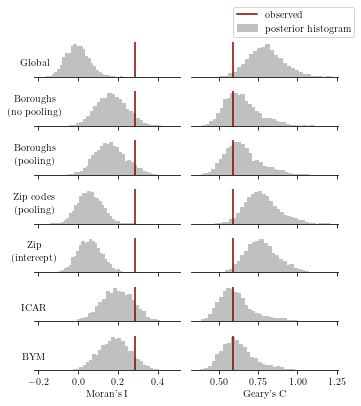

In [67]:
fig, axes = plt.subplots(sum(include), 2, figsize=(5, 0.75 * sum(include)), sharex="col")
post_ps = []

for i, (name, nick, do, fit) in enumerate(zip(names, nicks, include, fits)):
    print(i, name)
    
    if not do:
        continue
    
    aa, ab = axes[i]
    
    h = aa.set_ylabel(r"\begin{center}" + name.replace(" (", "\\\\ (") + r"\end{center}")
    h.set_rotation(0)
        
    morans = all_morans[nick]
    gearys = all_gearys[nick]
    
    moran_post_p = min((morans > obs_moran).mean(), (morans < obs_moran).mean())
    geary_post_p = min((gearys > obs_geary).mean(), (gearys < obs_geary).mean())
    post_ps.append([moran_post_p, geary_post_p])
        
    aa.hist(morans, density=True, label="posterior histogram", bins=32, histtype="stepfilled", color=gray, ec=gray)
    aa.axvline(obs_moran, color=red, label="observed")
    #aa.axvline(oos_moran, color=green, label="heldout")
    ab.hist(gearys, density=True, label="posterior histogram", bins=32, histtype="stepfilled", color=gray, ec=gray)
    ab.axvline(obs_geary, color=red, label="observed")
    #ab.axvline(oos_geary, color=green, label="heldout")
    sns.despine(left=True, top=True, right=True)
    aa.set_yticks([])
    ab.set_yticks([])
    aa.yaxis.set_label_coords(0, 0.25)


aa.set_xlabel("Moran's I")
ab.set_xlabel("Geary's C")
plt.tight_layout()

axes[0,1].legend(bbox_to_anchor=(0.25, 1))
plt.savefig(f"10k_figs/all_spatial.pdf", bbox_inches="tight")
plt.show()

In [68]:
spatial_post_ps = pd.DataFrame(post_ps, index=names, columns=["Moran's $I$", "Geary's $C$"])

In [69]:
print(spatial_post_ps.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Moran's \$I\$ &  Geary's \$C\$ \\
\midrule
Global                &      0.00000 &      0.02350 \\
Boroughs (no pooling) &      0.06225 &      0.35750 \\
Boroughs (pooling)    &      0.05975 &      0.33850 \\
Zip codes (pooling)   &      0.00000 &      0.02400 \\
Zip (intercept)       &      0.00000 &      0.02675 \\
ICAR                  &      0.12625 &      0.49350 \\
BYM                   &      0.09525 &      0.43500 \\
\bottomrule
\end{tabular}



In [70]:
all_mars = [glob_mars, nopool_mars, pool_mars, icar_mars, bym_mars, zippool_mars, intzippool_mars,]

In [116]:
mars_df = pd.DataFrame(
    [list(md.values()) for md in all_mars],
    index=names,
    columns=list(all_mars[0].keys()),
).T.mean()

In [117]:
print(mars_df.to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Global                &  0.020257 \\
Boroughs (no pooling) &  0.003762 \\
Boroughs (pooling)    &  0.003765 \\
Zip codes (pooling)   &  0.001984 \\
Zip (intercept)       &  0.002364 \\
ICAR                  &  0.011866 \\
BYM                   &  0.012074 \\
\bottomrule
\end{tabular}



In [73]:
all_injps = [glob_injury_post_ps, nopool_injury_post_ps, pool_injury_post_ps, icar_injury_post_ps, bym_injury_post_ps, zippool_injury_post_ps, intzippool_injury_post_ps,]

In [118]:
injps_df = pd.DataFrame(
    [list(ind.values()) for ind in all_injps],
    index=names,
    columns=list(all_injps[0].keys()),
).T.mean()

In [119]:
print(injps_df.to_latex())

\begin{tabular}{lr}
\toprule
{} &        0 \\
\midrule
Global                &  0.05805 \\
Boroughs (no pooling) &  0.44660 \\
Boroughs (pooling)    &  0.43565 \\
Zip codes (pooling)   &  0.42575 \\
Zip (intercept)       &  0.41340 \\
ICAR                  &  0.15065 \\
BYM                   &  0.15370 \\
\bottomrule
\end{tabular}



In [122]:
metrics = spatial_post_ps + 0
metrics["Injury p"] = injps_df
metrics["Mean average residual"] = mars_df
print(metrics.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Moran's \$I\$ &  Geary's \$C\$ &  Injury p &  Mean average residual \\
\midrule
Global                &      0.00000 &      0.02350 &   0.05805 &               0.020257 \\
Boroughs (no pooling) &      0.06225 &      0.35750 &   0.44660 &               0.003762 \\
Boroughs (pooling)    &      0.05975 &      0.33850 &   0.43565 &               0.003765 \\
Zip codes (pooling)   &      0.00000 &      0.02400 &   0.42575 &               0.001984 \\
Zip (intercept)       &      0.00000 &      0.02675 &   0.41340 &               0.002364 \\
ICAR                  &      0.12625 &      0.49350 &   0.15065 &               0.011866 \\
BYM                   &      0.09525 &      0.43500 &   0.15370 &               0.012074 \\
\bottomrule
\end{tabular}



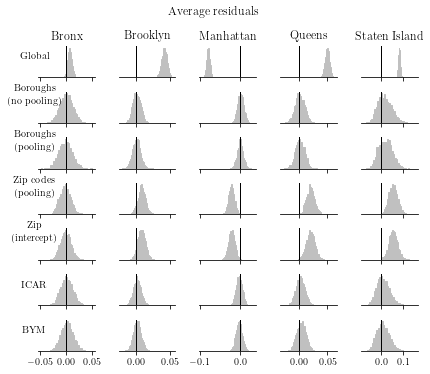

In [76]:
fig, axes = plt.subplots(sum(include), 5, figsize=(6, 0.75 * sum(include)), sharex="col")

for a, b in zip(axes[0], ("Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island")):
    a.set_title(b)

for i, (name, fit) in enumerate(zip(names, fits)):
    avg_residual_plot(fit, name, axes=axes[i])

fig.suptitle("Average residuals")
plt.tight_layout()
fig.savefig("10k_figs/all_avgres.pdf", bbox_inches="tight")

plt.show()

<ipython-input-78-7da50e36abd1>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


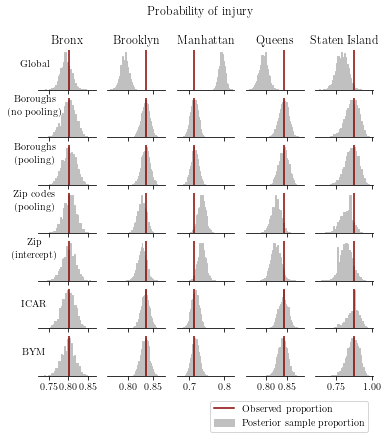

In [78]:
fig, axes = plt.subplots(len(fits), 5, figsize=(6, 6), sharex="col")

for a, b in zip(axes[0], ("Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island")):
    a.set_title(b)

for i, (name, fit) in enumerate(zip(names, fits)):
    injury_prob_plot(fit, name, axes=axes[i])
    
axes[-1, -1].legend(bbox_to_anchor=(1,-0.5))

fig.suptitle("Probability of injury")
plt.tight_layout()
fig.savefig("10k_figs/all_injprobs.pdf", bbox_inches="tight")

plt.show()

In [79]:
index = []
data = {"intercept": [], "b_rush_hour": [], "b_nighttime": []}

for i, (name, nick, do, fit) in enumerate(zip(names, nicks, include, fits)):
    if "orough" in name:
        continue
    index.append(name)
    for k in data:
        sv = fit.stan_variable(k)
        data[k].append([rf"${sv.mean():0.3g}\pm{sv.std():0.2g}$"])

print(pd.DataFrame(data, index=index).to_latex())

\begin{tabular}{llll}
\toprule
{} &         intercept &          b\_rush\_hour &        b\_nighttime \\
\midrule
Global              &   [\$1.3\textbackslash pm0.038\$] &    [\$0.047\textbackslash pm0.062\$] &  [\$0.119\textbackslash pm0.057\$] \\
Zip codes (pooling) &   [\$1.41\textbackslash pm0.43\$] &    [\$0.0109\textbackslash pm0.14\$] &   [\$0.142\textbackslash pm0.23\$] \\
Zip (intercept)     &   [\$1.42\textbackslash pm0.43\$] &  [\$0.00925\textbackslash pm0.064\$] &   [\$0.11\textbackslash pm0.058\$] \\
ICAR                &   [\$1.5\textbackslash pm0.051\$] &  [\$0.00398\textbackslash pm0.064\$] &  [\$0.114\textbackslash pm0.059\$] \\
BYM                 &  [\$1.49\textbackslash pm0.052\$] &   [\$0.0022\textbackslash pm0.064\$] &  [\$0.114\textbackslash pm0.059\$] \\
\bottomrule
\end{tabular}



## Geo plots

In [80]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

load up zip code network

In [81]:
children = yaml.safe_load(open("../data/children.yaml", "r"))
child2parent = {c: p for p, cs in children.items() for c in cs}

Census tract shapefiles

In [82]:
sf = shapefile.Reader(str(Path("../data/tl_2020_us_zcta510/tl_2020_us_zcta510.shx").resolve()))

In [83]:
pz_adj = yaml.safe_load(open("../data/parentadj.yaml", "r"))
allpzs = list(sorted(set(v for a, b in pz_adj.items() for v in (a, *b))))
pz_edges = set(
    (int(a), int(b)) if a <= b else (int(b), int(a))
    for a, bs in pz_adj.items()
    for b in bs
)
Nzips = len(allpzs)

In [84]:
pz2i = {pz: i for i, pz in enumerate(allpzs, 1)}
i2pz = dict(enumerate(allpzs, 1))

Map zip code to census tract shape for plotting

In [85]:
pzip2shapes = {}
for sr in sf.iterShapeRecords():
    z = int(sr.record["ZCTA5CE10"])
    if z in child2parent:
        pzip = child2parent[z]
    else:
        pzip = z
        
    if pzip in allpzs:
        cur_shapes = pzip2shapes.get(pzip, [])
        # https://gis.stackexchange.com/a/286865
        for i in range(len(sr.shape.parts)):
            i_start = sr.shape.parts[i]
            if i == len(sr.shape.parts)-1:
                i_end = len(sr.shape.points)
            else:
                i_end = sr.shape.parts[i+1]
            x = [i[0] for i in sr.shape.points[i_start:i_end]]
            y = [i[1] for i in sr.shape.points[i_start:i_end]]
            cur_shapes.append((x, y))
        pzip2shapes[pzip] = cur_shapes

In [86]:
cmap = plt.get_cmap("Purples")

Census tract plotting helper!

In [87]:
def plot_by_pzip(ax, pz2data, vmin, vmax, cm=cmap):
    for pzip, x in pz2data.items():
        if int(pzip) not in pzip2shapes:
            print(f"no shape for {pzip}...")
            continue
        shapes = pzip2shapes[int(pzip)]
        c = (x - vmin) / (vmax - vmin)
        for x, y in shapes:
            ax.fill(x, y, color=cm(c))

In [88]:
rates = sample_df.groupby('pzip')['injury'].mean()
true_injury_rate_by_pzip = rates.sort_values().to_dict()

In [89]:
counts = sample_df.groupby('pzip')['injury'].count()
count_by_pzip = counts.sort_values().to_dict()

In [90]:
counts.min(), counts.max()

(1, 231)

In [91]:
icar_probmeans = icar_fit.stan_variable("zip_pred_means").mean(axis=0)
icar_probmeans_by_pzip = {i2pz[i]: x for i, x in enumerate(icar_probmeans, 1)}

In [92]:
bym_probmeans = bym_fit.stan_variable("zip_pred_means").mean(axis=0)
bym_probmeans_by_pzip = {i2pz[i]: x for i, x in enumerate(bym_probmeans, 1)}

In [93]:
zippool_probmeans = zippool_fit.stan_variable("zip_pred_means").mean(axis=0)
zippool_probmeans_by_pzip = {i2pz[i]: x for i, x in enumerate(zippool_probmeans, 1)}

In [94]:
intzippool_probmeans = intzippool_fit.stan_variable("zip_pred_means").mean(axis=0)
intzippool_probmeans_by_pzip = {i2pz[i]: x for i, x in enumerate(intzippool_probmeans, 1)}

In [97]:
bymsum = bym_fit.summary()

no shape for 11698...
no shape for 11698...
no shape for 11698...
no shape for 11698...


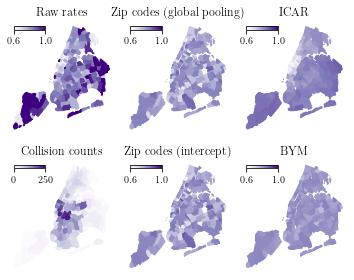

In [113]:
# Plot: spatial component by zip code

fig, axes = plt.subplots(2, 3, figsize=(5, 4))

for ax in axes.flat:
    sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)
    ax.set_xticks([])
    ax.set_yticks([])

(ae, ac, aa), (af, ad, ab) = axes

vmin = 0.6
vmax = 1.0

from matplotlib import cm, colors
mappable = cm.ScalarMappable(norm=colors.Normalize(vmin, vmax), cmap=cmap)

plot_by_pzip(aa, icar_probmeans_by_pzip, vmin, vmax) # icar_probmeans.min(), icar_probmeans.max())
aa.set_title("ICAR")

plot_by_pzip(ab, bym_probmeans_by_pzip, vmin, vmax) # bym_probmeans.min(), bym_probmeans.max())
ab.set_title("BYM")

plot_by_pzip(ac, zippool_probmeans_by_pzip, vmin, vmax) # zippool_probmeans.min(), zippool_probmeans.max())
ac.set_title("Zip codes (global pooling)")

plot_by_pzip(ad, intzippool_probmeans_by_pzip, vmin, vmax) # intzippool_probmeans.min(), intzippool_probmeans.max())
ad.set_title("Zip codes (intercept)")

plot_by_pzip(ae, true_injury_rate_by_pzip, vmin, vmax) # rates.min(), rates.max())
ae.set_title("Raw rates")

plot_by_pzip(af, count_by_pzip, 0, 250)
af.set_title("Collision counts")

plt.tight_layout()

cbaxes = inset_axes(aa, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(ab, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(ac, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(ad, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(ae, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(af, width="30%", height="3%", loc=2) 
plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(0, 250), cmap=cmap), cax=cbaxes, ticks=[0,250], orientation='horizontal')

fig.savefig("10k_figs/10k_spatialcomp.pdf")
plt.show()

In [123]:
# Plot: posterior mean by zip code

In [99]:
icar_postmeans = icar_fit.stan_variable("injury_rep").mean(axis=0)
icar_pzip_postmeans = pd.Series(icar_postmeans).groupby(sample_df["pzip"]).mean().sort_values().to_dict()

In [100]:
bym_postmeans = bym_fit.stan_variable("injury_rep").mean(axis=0)
bym_pzip_postmeans = pd.Series(bym_postmeans).groupby(sample_df["pzip"]).mean().sort_values().to_dict()

In [101]:
zippool_postmeans = zippool_fit.stan_variable("injury_rep").mean(axis=0)
zippool_pzip_postmeans = pd.Series(zippool_postmeans).groupby(sample_df["pzip"]).mean().sort_values().to_dict()

In [102]:
intzippool_postmeans = intzippool_fit.stan_variable("injury_rep").mean(axis=0)
intzippool_pzip_postmeans = pd.Series(intzippool_postmeans).groupby(sample_df["pzip"]).mean().sort_values().to_dict()

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


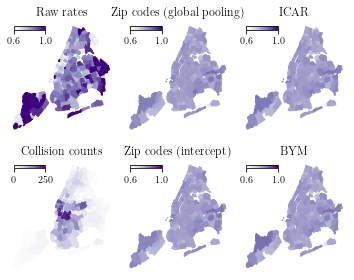

In [106]:
fig, axes = plt.subplots(2, 3, figsize=(5, 4))

for ax in axes.flat:
    sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)
    ax.set_xticks([])
    ax.set_yticks([])

(ae, ac, aa), (af, ad, ab) = axes

vmin = 0.6
vmax = 1.0

from matplotlib import cm, colors
mappable = cm.ScalarMappable(norm=colors.Normalize(vmin, vmax), cmap=cmap)

plot_by_pzip(aa, icar_pzip_postmeans, vmin, vmax) # icar_probmeans.min(), icar_probmeans.max())
aa.set_title("ICAR")

plot_by_pzip(ab, bym_pzip_postmeans, vmin, vmax) # bym_probmeans.min(), bym_probmeans.max())
ab.set_title("BYM")

plot_by_pzip(ac, zippool_pzip_postmeans, vmin, vmax) # zippool_probmeans.min(), zippool_probmeans.max())
ac.set_title("Zip codes (global pooling)")

plot_by_pzip(ad, intzippool_pzip_postmeans, vmin, vmax) # intzippool_probmeans.min(), intzippool_probmeans.max())
ad.set_title("Zip codes (intercept)")

plot_by_pzip(ae, true_injury_rate_by_pzip, vmin, vmax) # rates.min(), rates.max())
ae.set_title("Raw rates")

plot_by_pzip(af, count_by_pzip, 0, 250)
af.set_title("Collision counts")

plt.tight_layout()

cbaxes = inset_axes(aa, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(ab, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(ac, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(ad, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(ae, width="30%", height="3%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, ticks=[vmin,vmax], orientation='horizontal')
cbaxes = inset_axes(af, width="30%", height="3%", loc=2) 
plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(0, 250), cmap=cmap), cax=cbaxes, ticks=[0,250], orientation='horizontal')

plt.savefig("10k_figs/10k_postmeans.pdf")
plt.show()